In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
#import utils
import ampds_preprocessing
from time import time
%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/home/camilo/anaconda3/envs/nilm/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


### Convertir base en dataframe
AMPds se puede bajar desde https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FIE0S4. Dentro del zip esta el archivo AMPds2.h5

In [2]:
path_h5  = 'ampds2.h5'
df = ampds_preprocessing.get_df_per_day(path_h5)

In [3]:
#df = df.rename(columns=ampds_preprocessing.FULL_NAME)

In [4]:
# divide los dataframes entre agregados y desagregados
individual = df.loc[:, df.columns.get_level_values('name')!='WHE']
aggregate = df.loc[:, df.columns.get_level_values('name')=='WHE']

In [5]:
n_days, _ = aggregate.columns.levshape
f'Se tienen {n_days} días de datos'

'Se tienen 726 días de datos'

Text(0.5, 1.0, 'Señales de corriente')

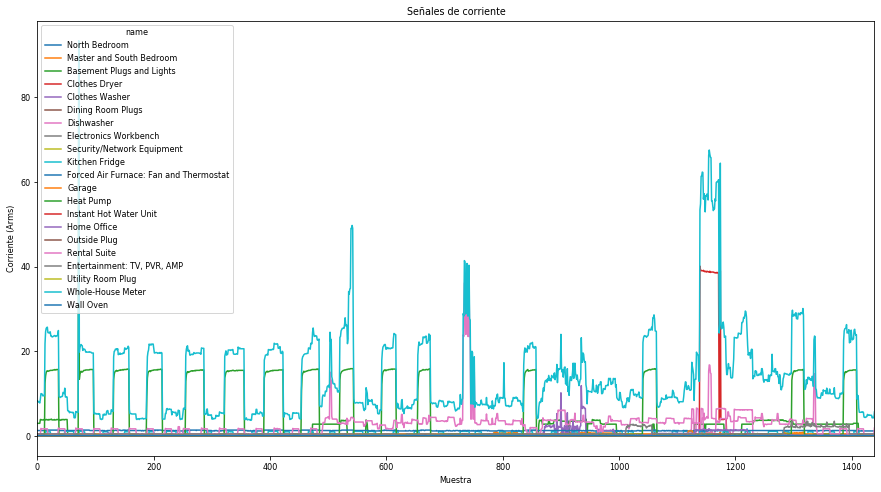

In [6]:
rcParams['font.style'] = 'normal'
rcParams['font.size'] = 8
rcParams['font.weight'] = 'normal'
df[0].rename(columns=ampds_preprocessing.FULL_NAME).plot(figsize=(15,8))
plt.xlabel('Muestra')
plt.ylabel('Corriente (Arms)')
plt.title('Señales de corriente')

In [7]:
DAYS_TO_TRAIN = 300
DAYS_TO_EVAL = 60
D = individual.loc[:, 0:DAYS_TO_TRAIN].to_numpy()
D[D<0] = 0
X = aggregate.loc[:, 715-DAYS_TO_EVAL:715].to_numpy()
X[X<0] = 0
np.save('X.npy', X)
np.save('D.npy', D)

In [8]:
D.shape, X.shape

((1440, 6020), (1440, 61))

In [34]:
# from fnnls import fnnls
# from time import time
# from scipy.optimize import nnls
# #from nnls import nnls

# from time import time
# As = list()
# costs = list()
# for i, x in enumerate(X.T):
#     t1 = time()
#     A, cost = nnls(D, x)
#     As.append(A)
#     costs.append(cost)
#     t2 = time()
#     print(f'[{i}] Costo: {cost}\t\tTiempo: {t2-t1:.2f}')
#     print()

In [35]:
# A = np.vstack(As).T
# np.save('A_opt.npy', A)

# Problema a resolver
Se intenta resolver un problema similar al del paper https://arxiv.org/pdf/1704.07308.pdf. El problema es el siguiente:
$$min_A ||X - DA||_{F}^2$$

$$\text{ s.t. $A_{i,j}>0$ $\forall i,j$}$$

- $D$ (Matriz de diccionario): Es una matriz cuyas columnas son las bases del consumo de energeia electrico (se espera poder estimar el consumo sea una combinación lineal de estos vectores).

- $X$ (Matriz de datos a proyectar): Es una matriz en la que cada columna representa el consumo electrico de que se quiere proyectar sobre las columnas de $D$.

## Implementación
Se implementa mediante apgd. El tipo de aceleración que se elige es ADAM.

In [36]:
from apgd import adam_pgd
t1 = time()
A, cost = adam_pgd(D, X)
t2 = time()
print(f'Tiempo: {t2-t1:.1f}')

[iter:0]	5453737.00
[iter:1000]	477775.94
[iter:2000]	461166.75
[iter:3000]	453792.28
[iter:4000]	449520.16
[iter:5000]	446899.34
[iter:6000]	445220.78
[iter:7000]	444120.06
[iter:8000]	443346.28
[iter:9000]	442796.91
[iter:10000]	442418.12
[iter:11000]	442159.75
[iter:12000]	441979.16
[iter:13000]	441852.31
[iter:14000]	441765.66
[iter:15000]	441705.53
[iter:16000]	441660.84
[iter:17000]	441627.00
[iter:18000]	441602.34
[iter:19000]	441585.62
[iter:20000]	441575.34
[iter:21000]	441569.75
[iter:22000]	441567.47
[iter:23000]	441566.91
[iter:24000]	441566.81
[iter:25000]	441566.81
[iter:26000]	441566.81
[iter:27000]	441566.81
[iter:28000]	441566.81
[iter:29000]	441566.81
[iter:30000]	441566.81
[iter:31000]	441566.81
[iter:32000]	441566.81
[iter:33000]	441566.81
[iter:34000]	441566.81
[iter:35000]	441566.81
[iter:36000]	441566.81
[iter:37000]	441566.81
[iter:38000]	441566.81
[iter:39000]	441566.81
[iter:40000]	441566.91
[iter:41000]	441566.81
[iter:42000]	441566.81
[iter:43000]	441566.81


In [137]:
sum_current_total = X.sum(axis=0)

names = list(ampds_preprocessing.FULL_NAME.keys())
names.remove('WHE')
sum_current_elec = np.empty((len(names), X.shape[1]))
for i, s in enumerate(names):
    # Mascara para tener solo el electrodomestico de interes
    mask = (individual.columns.get_level_values('name')==s)[0:A.shape[0]]

    # A enmascarado poniendo a 0 todos los coeficientes que no son del
    # electrodomestico de interes
    A_mask = A * mask[:,np.newaxis]
    serie_elec = D @ A_mask

    # Suma de corriente consumida por dia para este electrodomestico
    sum_current_elec[i] = serie_elec.sum(axis=0)

In [138]:
columns.shape, DAYS_TO_EVAL+1,716

((21,), 21, 716)

In [139]:
columns = pd.RangeIndex(715-DAYS_TO_EVAL,716)

sumas_corriente = pd.DataFrame(sum_current_elec, index=names, columns=columns)
sumas_corriente = sumas_corriente.sum(axis=1)#.rename(ampds_preprocessing.FULL_NAME)
ground_truth = individual.loc[:, DAYS_TO_TRAIN+1:715].sum(axis=0).unstack(level=0)
ground_truth = ground_truth.sum(axis=1)#.rename(ampds_preprocessing.FULL_NAME)

In [140]:
full_names = list(ampds_preprocessing.FULL_NAME.values())
full_names.remove('Whole-House Meter')
full_names = list(enumerate(full_names))
full_names = list(map(lambda x:str(x[0]+1)+'-'+x[1], full_names))

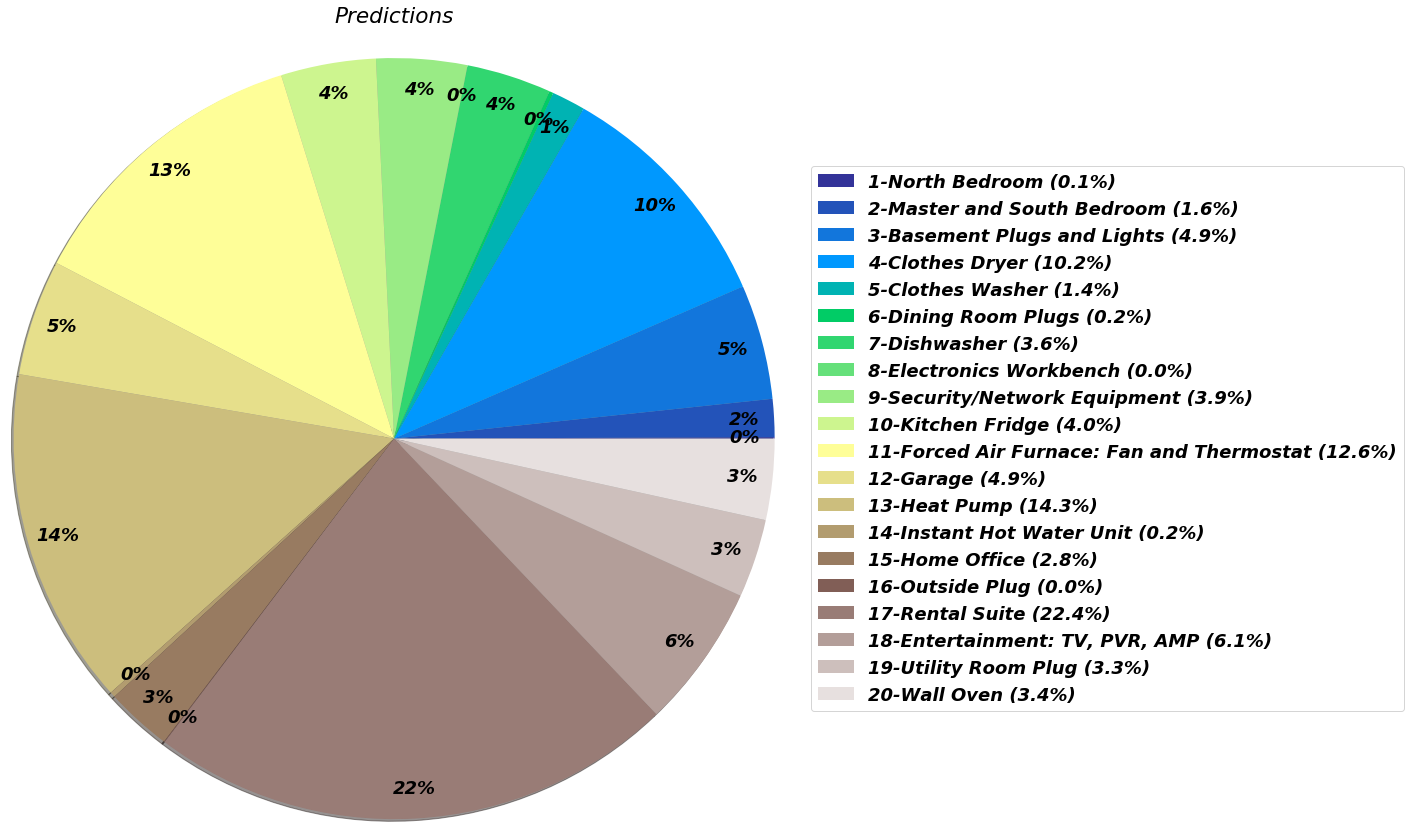

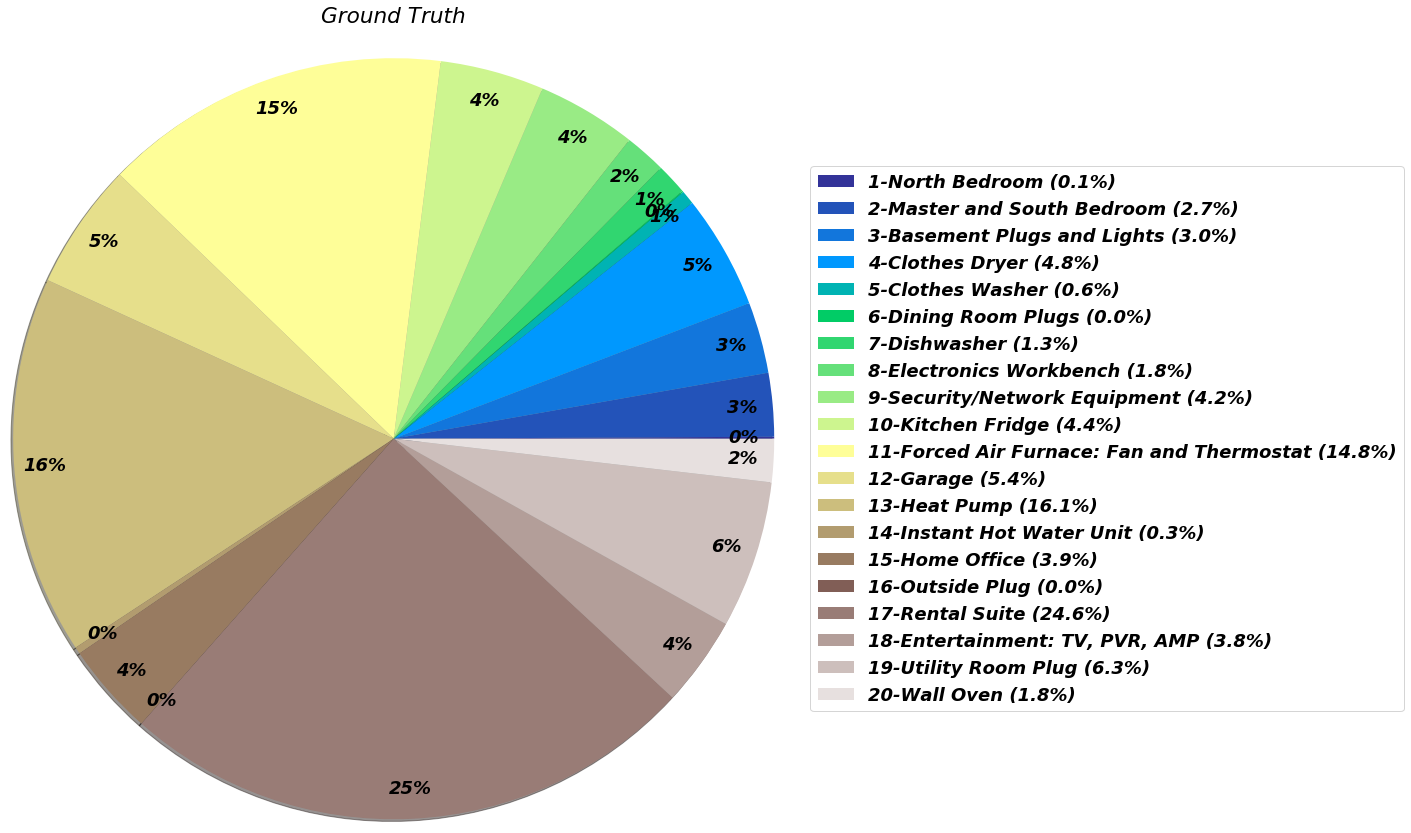

In [141]:
def add_percentege_to_names(x, full_names):
    tot = x.sum()
    percentages = list(map(lambda x:f' ({x/tot*100:.1f}%)', x))
    names = zip(full_names, percentages)
    names = list(map(lambda x:x[0]+x[1], names))
    return names

def plot_pie(x):
    rcParams['font.style'] = 'oblique'
    rcParams['font.size'] = 18
    rcParams['font.weight'] = 'heavy'

    fig1, ax1 = plt.subplots(figsize=(6, 5))

    theme = plt.get_cmap('terrain')
    ax1.set_prop_cycle("color", [theme(1. * i / len(x)) for i in range(len(x))])
    
    ax1.pie(x, 
            autopct='%1.0f%%', 
            radius=3.5, 
            shadow=True, 
            pctdistance=0.92,)
    names = add_percentege_to_names(x, full_names)
    ax1.legend(names,
               loc="center left",
               bbox_to_anchor=(2, 0, 0.5, 1))

plot_pie(sumas_corriente.to_numpy())
#plt.title('Predictions')
plt.title('Predictions', pad=(280))
plt.savefig('prediction.png', bbox_inches='tight')

plot_pie(ground_truth.to_numpy())
plt.title('Ground Truth', pad=(280))
plt.savefig('ground_truth.png', bbox_inches='tight')

In [170]:
mask = (individual.columns.get_level_values('name')=='CWE')[0:A.shape[0]]
real = individual.loc[:, 715-DAYS_TO_EVAL:715][695]['CWE'].to_numpy()

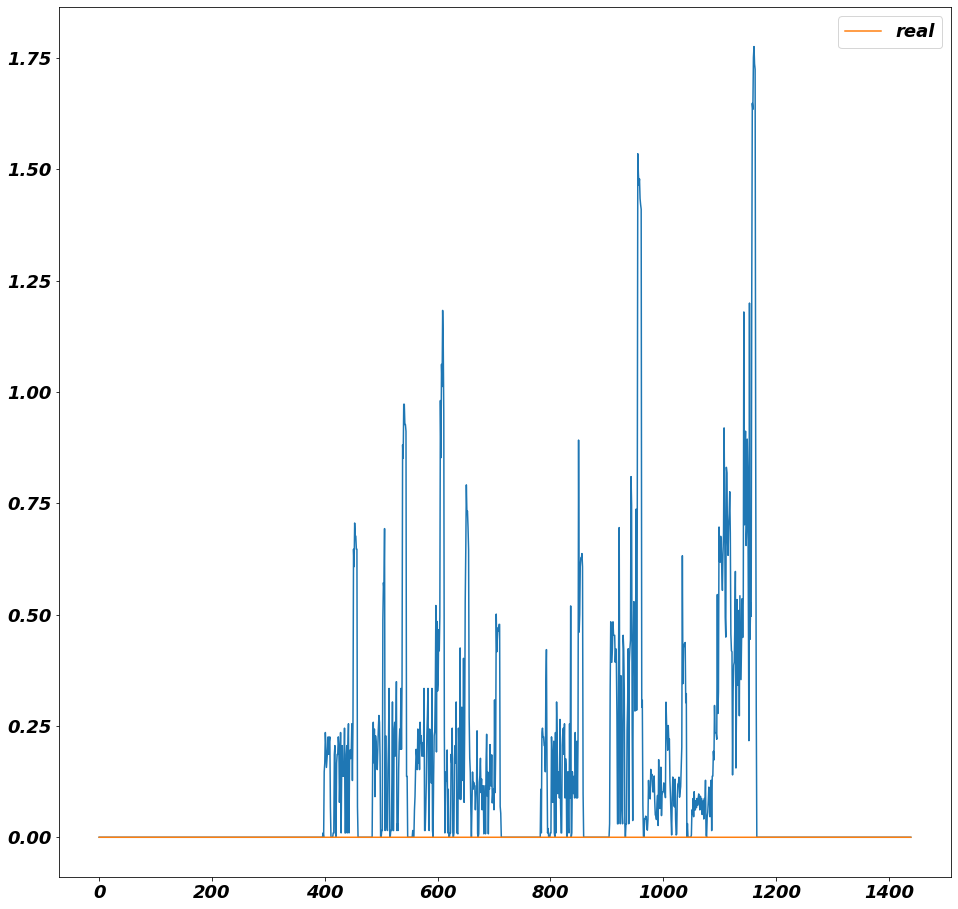

In [171]:
plt.figure(figsize=(16,16))
plt.plot(D @ (A[:, 0] * mask))
plt.plot(real, label='real')
#plt.plot(X[:, 0], label='real')
plt.legend()

In [126]:
names = list(ampds_preprocessing.FULL_NAME.keys())
names.remove('WHE')
sum_current_elec = np.empty((len(names), X.shape[1]))
mask = np.zeros(A.shape[0], dtype=int)
for i, s in enumerate(names):
    # Mascara para tener solo el electrodomestico de interes
    mask[(individual.columns.get_level_values('name')==s)[0:A.shape[0]]] = i
n_mask = len(names)

In [117]:
from apgd import adam_pgd
t1 = time()
A, cost = adam_pgd(D, X, mask=mask, n_mask=n_mask, lr=1e-4)
t2 = time()
print(f'Tiempo: {t2-t1:.1f}')

[iter:0]	5453737.00
Tiempo: 5.8


In [118]:
A.shape, mask.shape, mask.dtype

((2020, 21), (2020,), dtype('bool'))

In [119]:
eps = 1e-10
res = A[mask==1]#/(A[mask==1].sum(axis=0) + eps)
res.sum(axis=0)

array([0.9999991 , 1.000001  , 0.99999917, 0.9999991 , 0.99999917,
       1.0000005 , 1.0000012 , 1.0000008 , 0.99999946, 1.0000014 ,
       0.999999  , 0.9999991 , 0.9999994 , 0.99999857, 1.0000008 ,
       0.9999991 , 0.9999995 , 0.9999992 , 0.99999964, 1.0000013 ,
       1.        ], dtype=float32)

In [112]:
A[mask==2].sum(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)

In [132]:
import torch
from torch  import optim
device = 'cuda'
A0 = None
verbose = True

lr: float = 1e-6
betas=(0.9, 0.999)
max_iter = 70_000
X = torch.tensor(X, device=device, dtype=torch.float32)
D = torch.tensor(D, device=device, dtype=torch.float32)
f = lambda A: torch.norm(X-D@A)**2
if mask is not None: mask = torch.tensor(mask, device=device)

if A0 is None:
    A = torch.zeros((D.shape[1], X.shape[1]), device=device, 
                     dtype=torch.float32, requires_grad=True)
else:
    A = torch.tensor(A0, device=device, dtype=torch.float32,
                      requires_grad=True)

optimizer = optim.Adam([A], lr=lr, betas=betas)

for k in range(max_iter):
    optimizer.zero_grad()
    loss = f(A)
    loss.backward()
    optimizer.step()
    if k%1000==0 and verbose:
        print(f'[iter:{k}]\t{float(loss):.2f}')

    with torch.no_grad():
        A.clip_(0, None)
        if mask is not None:
            eps = 1e-10
            for i in range(n_mask):
                A[mask==i] /= (A[mask==i].sum(dim=0) + eps)

<ipython-input-132-7723fd79c3c5>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=device, dtype=torch.float32)
<ipython-input-132-7723fd79c3c5>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(D, device=device, dtype=torch.float32)
<ipython-input-132-7723fd79c3c5>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if mask is not None: mask = torch.tensor(mask, device=device)


[iter:0]	5453737.00
[iter:1000]	1862929.75
[iter:2000]	1839064.12
[iter:3000]	1816082.00
[iter:4000]	1793912.25
[iter:5000]	1772443.38
[iter:6000]	1751562.12
[iter:7000]	1731205.12
[iter:8000]	1711641.38
[iter:9000]	1693047.00
[iter:10000]	1675302.00
[iter:11000]	1658464.12
[iter:12000]	1642872.38
[iter:13000]	1628135.50
[iter:14000]	1613908.12
[iter:15000]	1600162.00
[iter:16000]	1587002.38
[iter:17000]	1574485.50
[iter:18000]	1562767.62
[iter:19000]	1552016.88
[iter:20000]	1542460.62
[iter:21000]	1534574.12
[iter:22000]	1528602.00
[iter:23000]	1523654.88
[iter:24000]	1519568.75
[iter:25000]	1514257.00
[iter:26000]	1511072.38
[iter:27000]	1509387.75
[iter:28000]	1508866.50
[iter:29000]	1509543.12
[iter:30000]	1511034.00
[iter:31000]	1512634.88
[iter:32000]	1514671.00
[iter:33000]	1517249.25
[iter:34000]	1520146.88
[iter:35000]	1522986.50
[iter:36000]	1522700.00
[iter:37000]	1522172.50
[iter:38000]	1521676.12
[iter:39000]	1521281.00
[iter:40000]	1520895.62
[iter:41000]	1520591.88
[iter

In [136]:
A = np.array(A.detach().cpu())